# Import data

In [1]:
import pandas as pd

df_tissue = pd.read_csv('./dataset/dataset_tissue.txt',sep=',',index_col=0)
df_clases = pd.read_csv('./dataset/clase.txt',sep=',',index_col=0)

# PCA

In [2]:
from sklearn.decomposition import PCA

df_tissue_transposed = df_tissue.T
n_components = 70
pca = PCA(n_components=n_components)
dt_tissue_pca = pca.fit_transform(df_tissue_transposed)

# K-means

In [3]:
import numpy as np

def distance(v1, v2):
    return np.linalg.norm(v1 - v2)

def init_centroids(data, k):
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    return centroids

def assign_clusters(data, centroids):
    return np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)

def update_centroids(data, clusters, k):
    new_centroids = np.array([data[clusters == i].mean(axis=0) if np.sum(clusters == i) != 0 else data[np.random.choice(data.shape[0], 1)][0] for i in range(k)])
    return new_centroids

def average_centroid_distance(old_centroids, new_centroids):
    return np.mean([distance(old_centroids[i], new_centroids[i]) for i in range(len(old_centroids))])

def kmeans(data, k, threshold):
    centroids = init_centroids(data, k)
    clusters = assign_clusters(data, centroids)
    new_centroids = update_centroids(data, clusters, k)
    
    while average_centroid_distance(centroids, new_centroids) > threshold:
        centroids = new_centroids
        clusters = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, clusters, k)
    
    return new_centroids, clusters


# Método del codo (Elbow)
Este método sirve para determinar el número óptimo de clústeres en un conjunto de datos utilizando la implementación del k-means.
- Calculate_inertia, la inercia es una medida de la suma de las distancias cuadradas de cada punto de datos al centroide de su clúster correspondiente.
- Elblow_method, sirve para calcular la inercia para diferentes valores de k y almacena los resultados en una lista.

Para esta experimentación, el rango de clústeres va desde 1 hasta 11 y con un un rango de umbral de convergencia desde 0.5 hasta 7 con 0.5 de aumento en cada paso. Generando las siguientes gráficas.

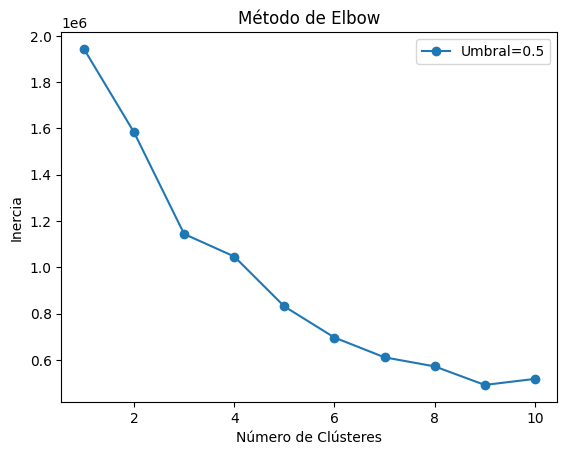

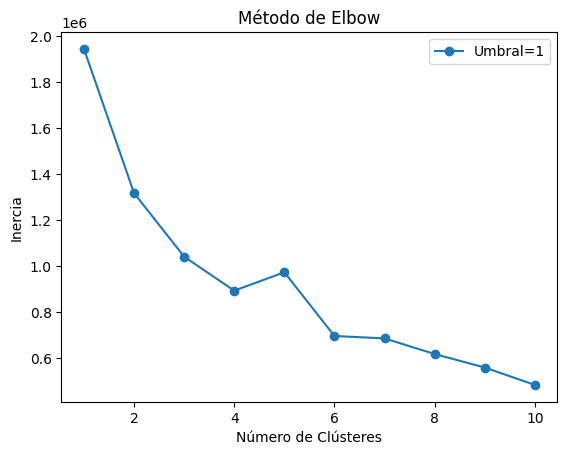

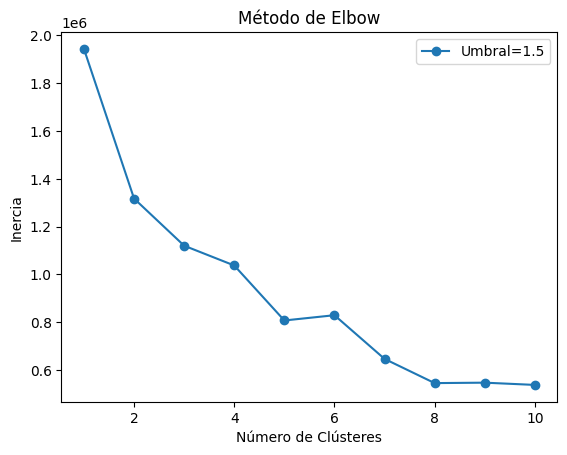

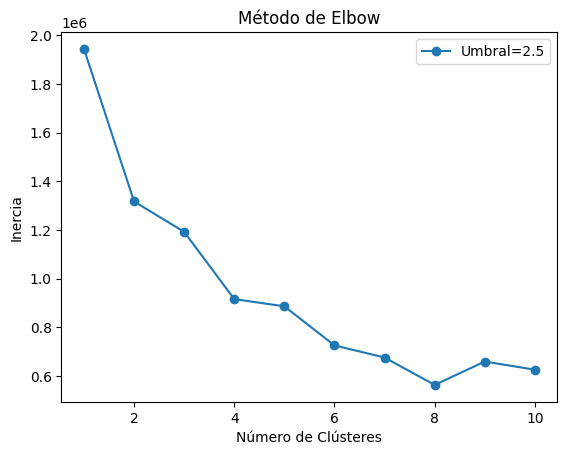

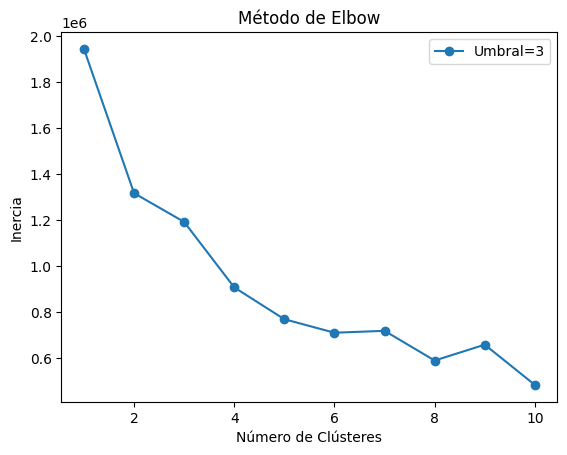

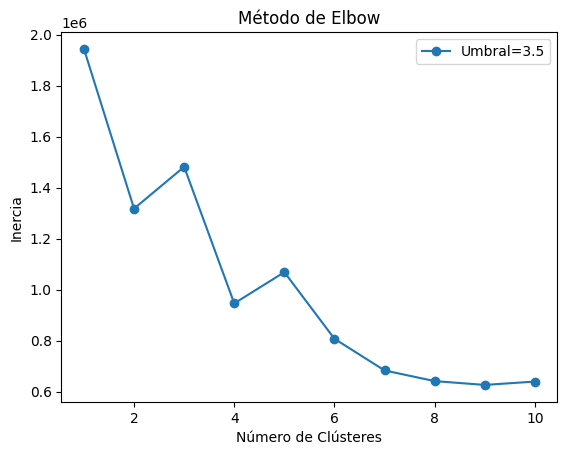

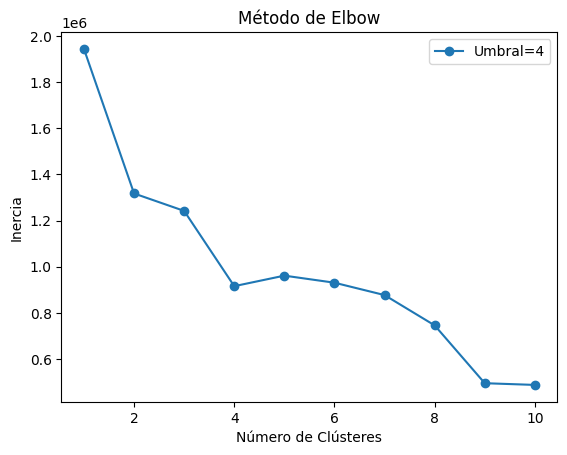

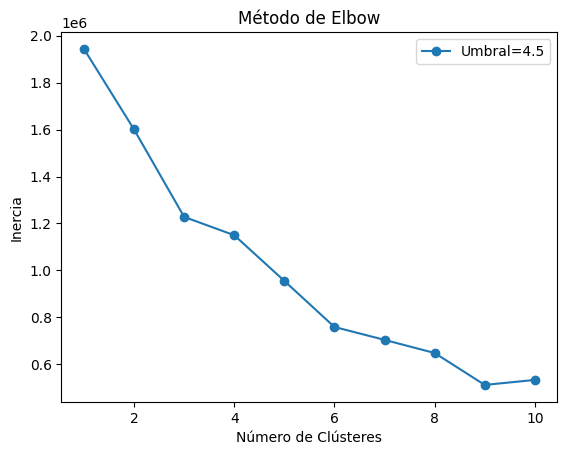

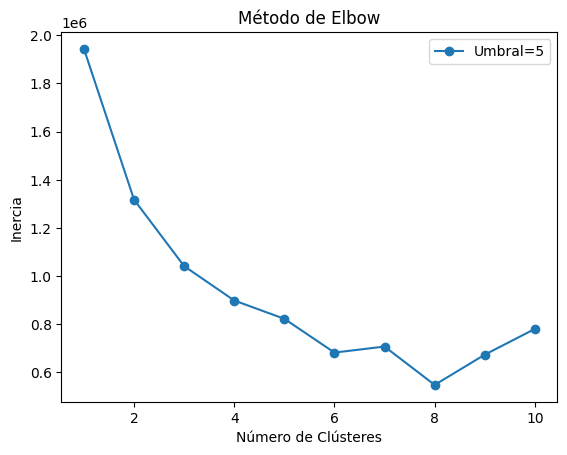

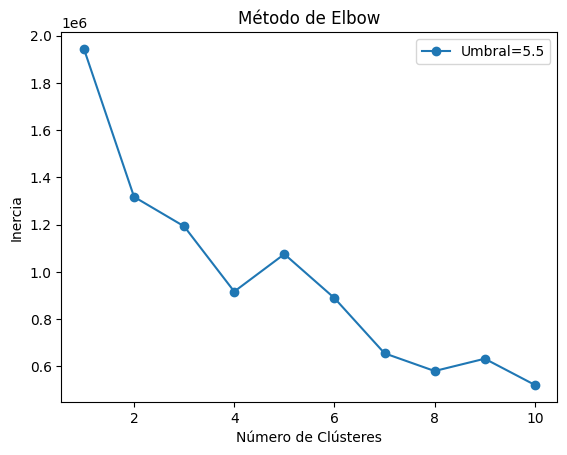

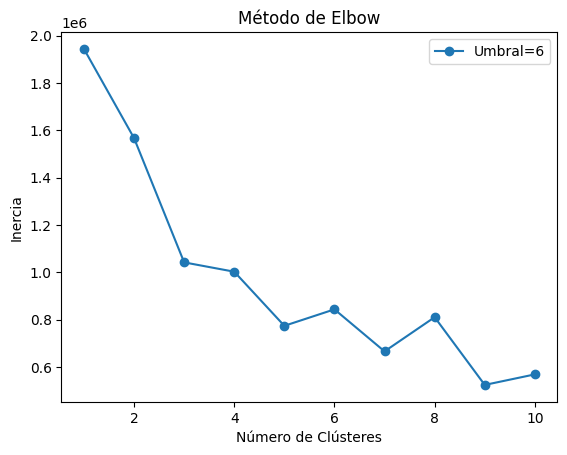

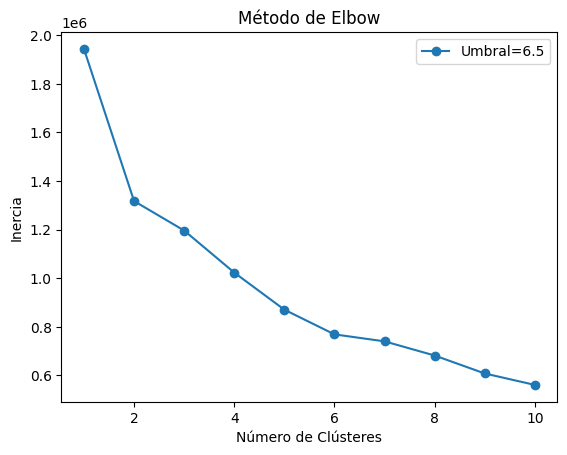

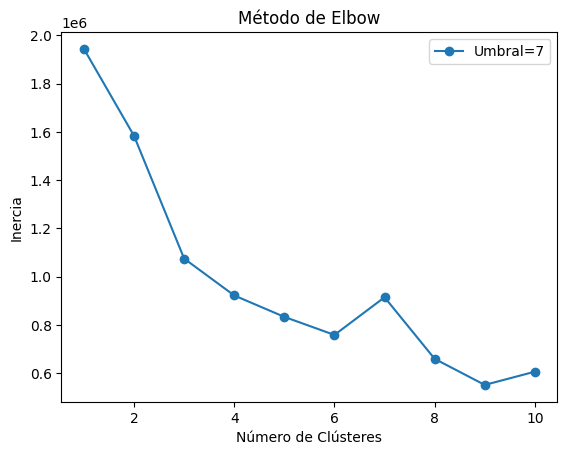

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define la función para calcular la inercia
def calculate_inertia(data, centroids, clusters):
    inertia = 0
    for i in range(len(centroids)):
        inertia += np.sum((data[clusters == i] - centroids[i])**2)
    return inertia

# Define la función para la métrica de elbow
def elbow_method(data, k_range, threshold):
    inertias = []
    for k in k_range:
        centroids, clusters = kmeans(data, k, threshold)
        inertia = calculate_inertia(data, centroids, clusters)
        inertias.append(inertia)
    return inertias

# Define los parámetros
k_range = range(1, 11)
umbral_values = [0.5,1,1.5,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]

for umbral in umbral_values:
    inertias = elbow_method(dt_tissue_pca, k_range, umbral)

    plt.plot(k_range, inertias, '-o', label=f'Umbral={umbral}')
    plt.xlabel('Número de Clústeres')
    plt.ylabel('Inercia')
    plt.title('Método de Elbow')
    plt.legend()
    plt.show()


## Análisis de gráficas

Analizando todas las gráficas, notaremos que las que destacan son las siguientes, la cual lo usaremos como punto de partida para la métrica de la silueta. Además podemos notar que hay casos donde no se ve claramente el cluster a elegir pero en promedio, rondan entre el 6 hasta el 8.
| Imagen | Descripción |
| --- | --- |
| ![image1](./resultados/elbow/6_15.png) | Gráfica 1 |
| ![image2](./resultados/elbow/6_35.png) | Gráfica 2 |
| ![image3](./resultados/elbow/6_45.png) | Gráfica 3 |
| ![image4](./resultados/elbow/7_3.png) | Gráfica 4 |
| ![image5](./resultados/elbow/7_7.png) | Gráfica 5 |
| ![image6](./resultados/elbow/7_65.png) | Gráfica 6 |
| ![image7](./resultados/elbow/8_4.png) | Gráfica 7 |

Usaremos estas umbrales y clusteres en una lista para la métrica de silueta.
## Silhouette
Mide la calidad del agrupamiento o clustering, usa la distancia de separación entre los clústeres. Nos indica como de cerca está cada punto de un cluster a puntos de los clústers vecinos. Esta medida de distancia se encuentra en el rango [-1, 1]. Un valor alto indica un buen clustering.

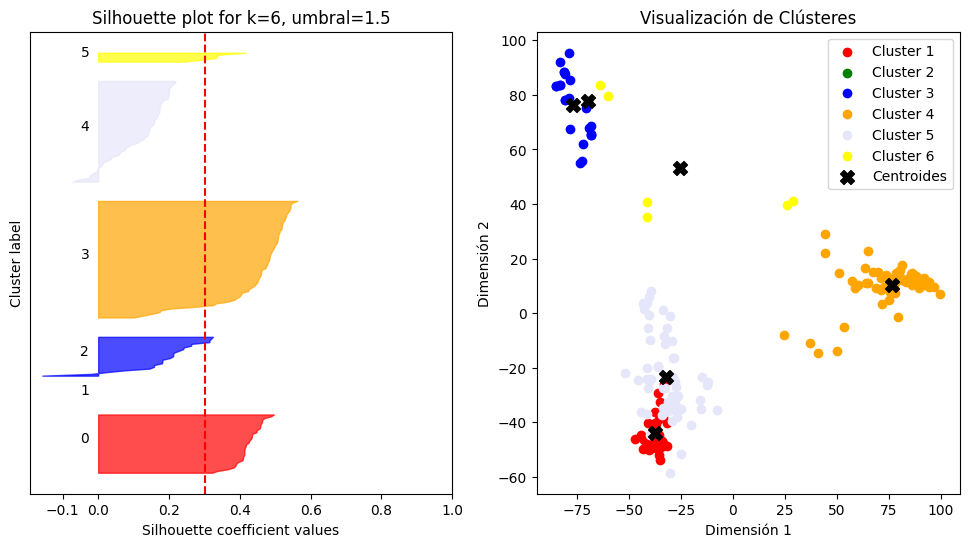

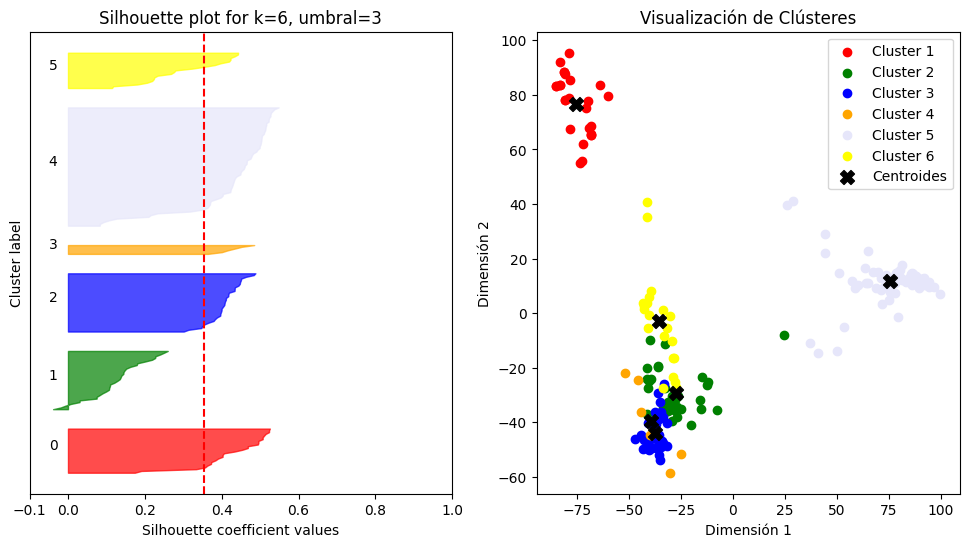

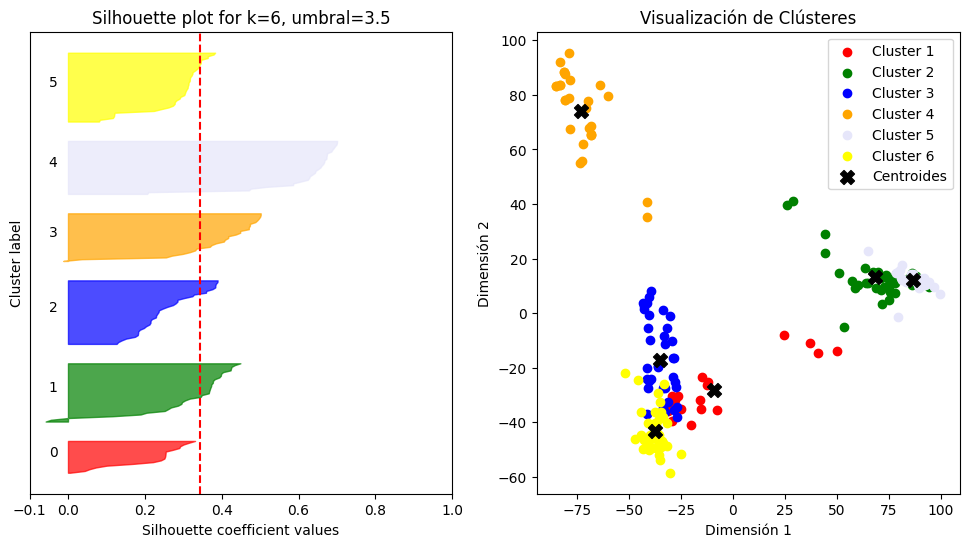

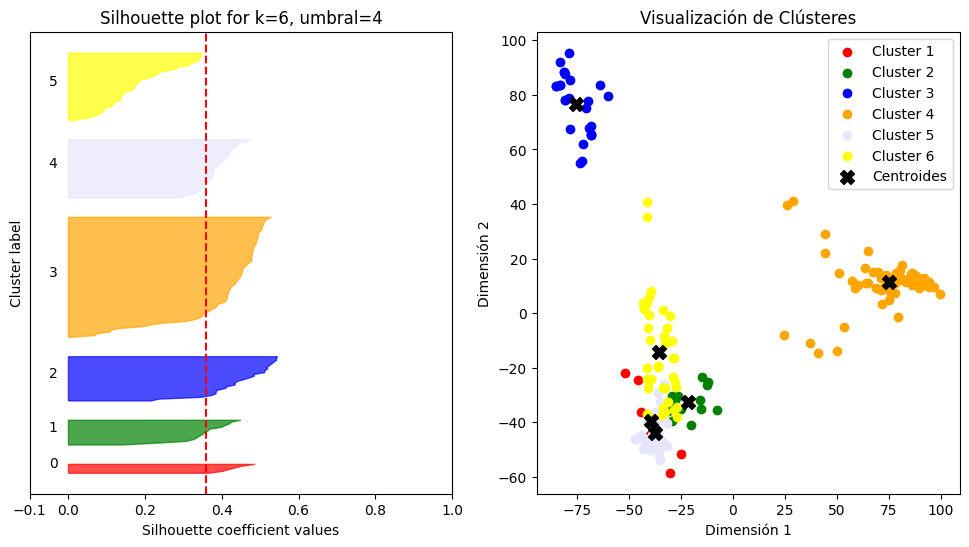

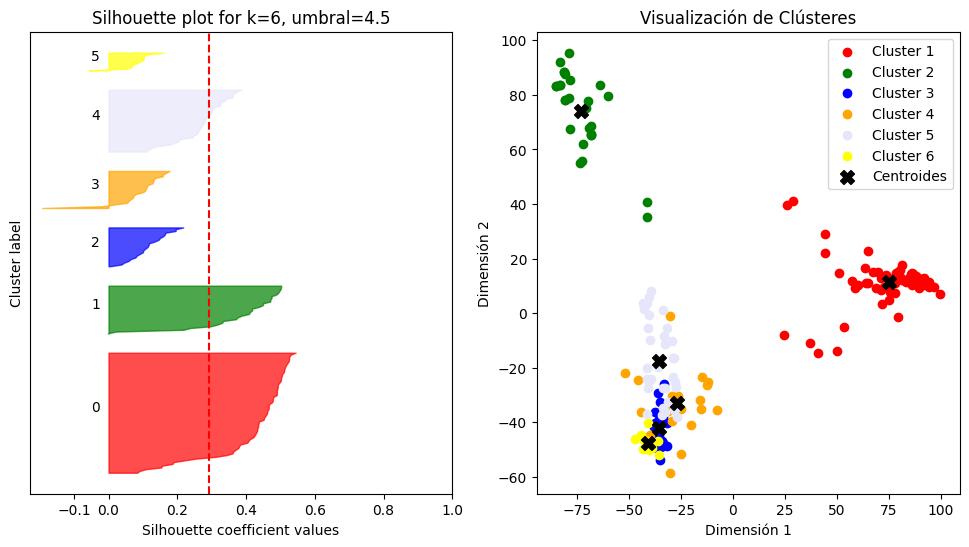

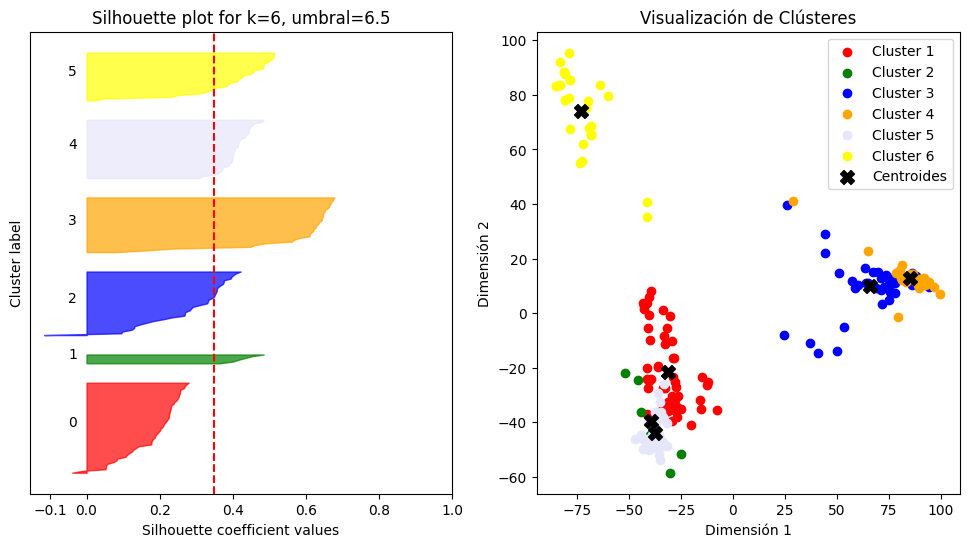

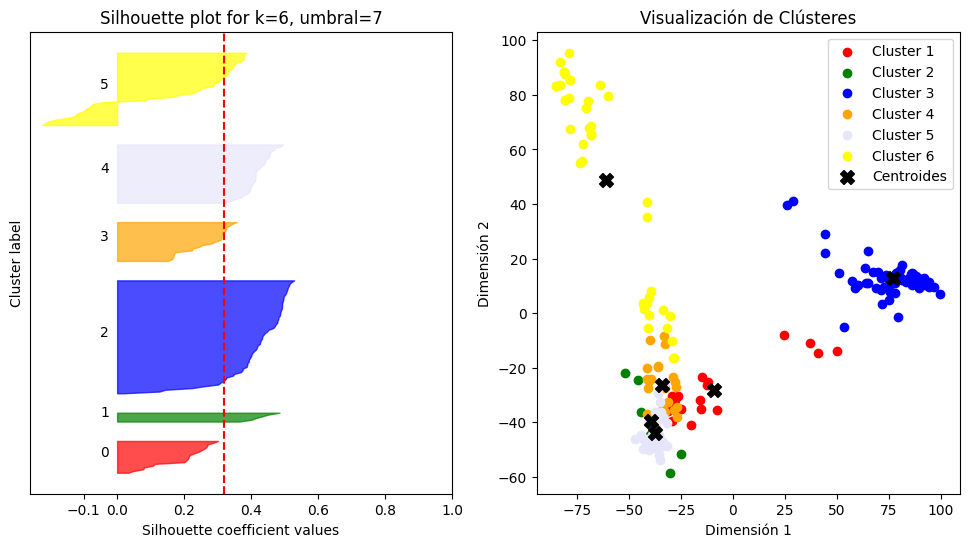

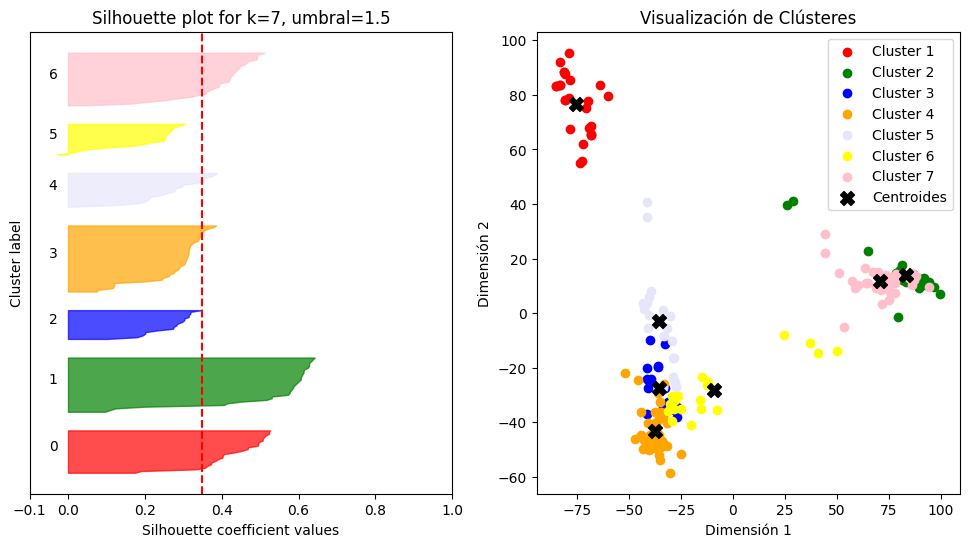

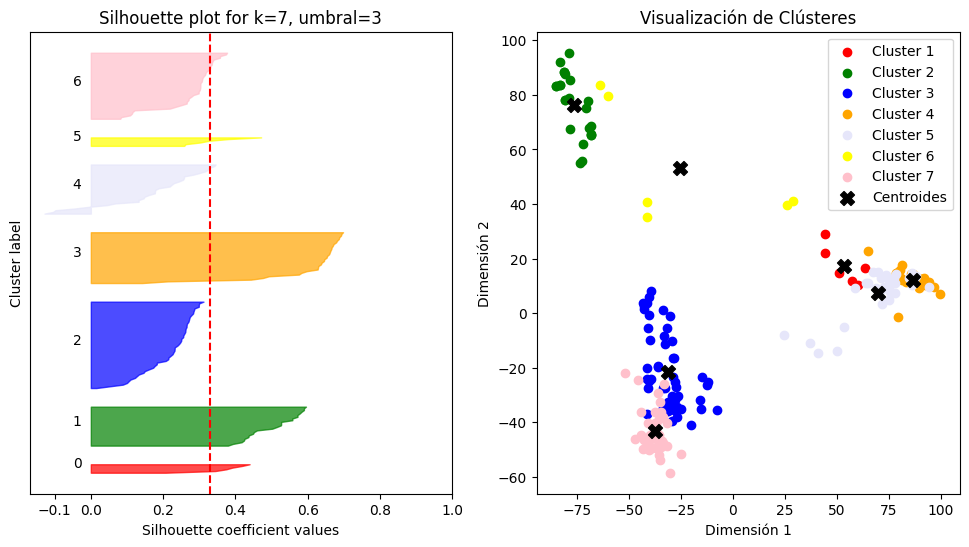

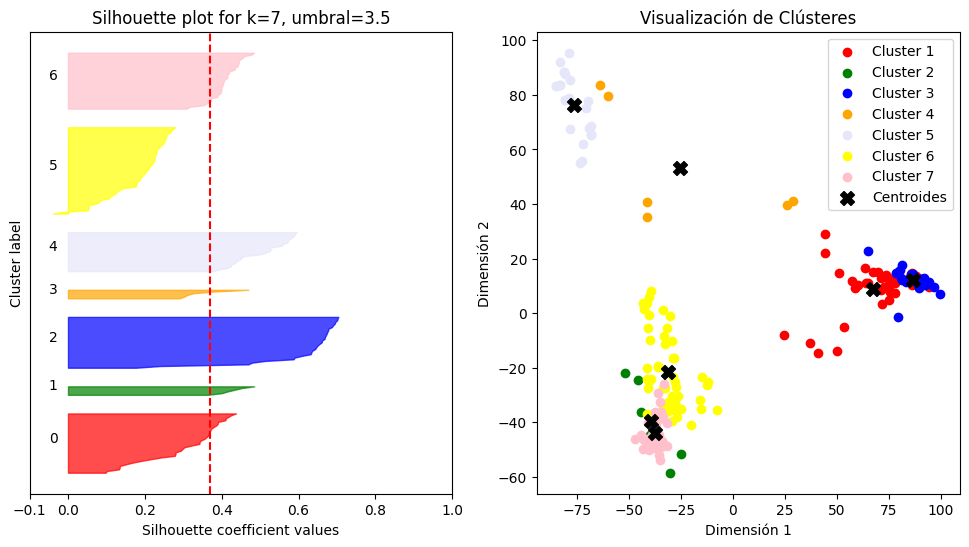

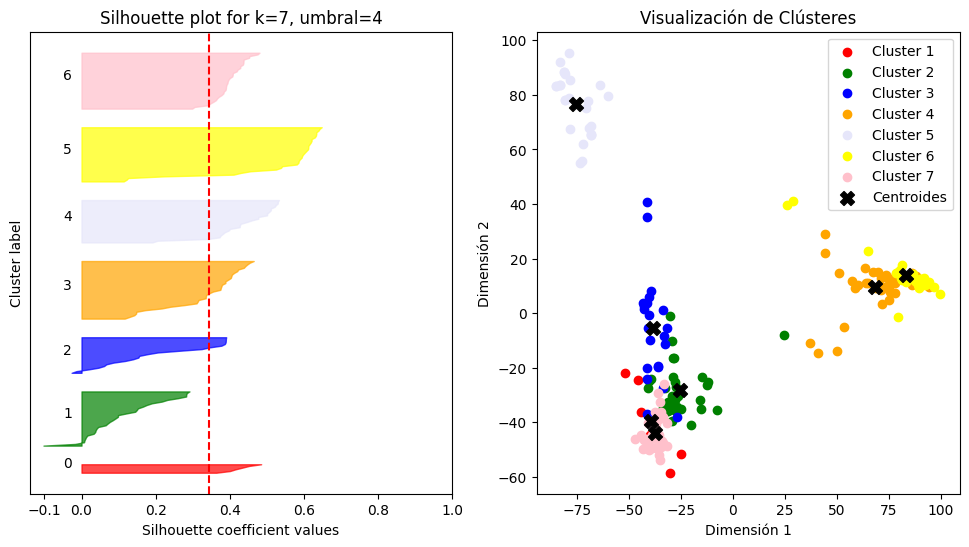

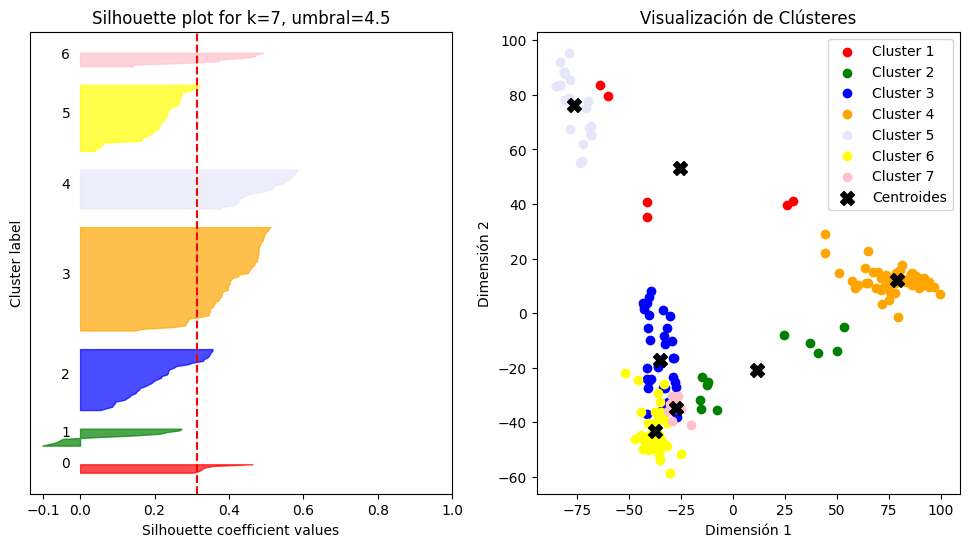

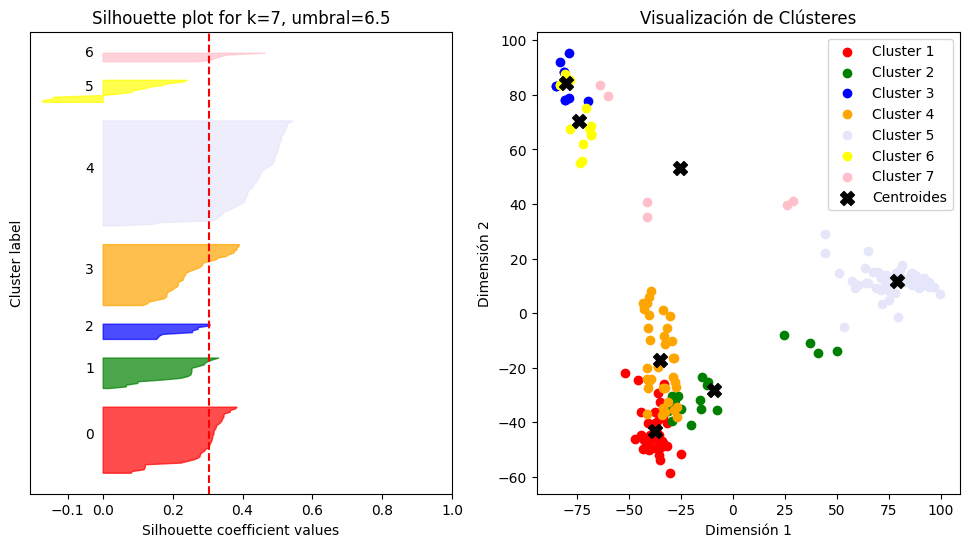

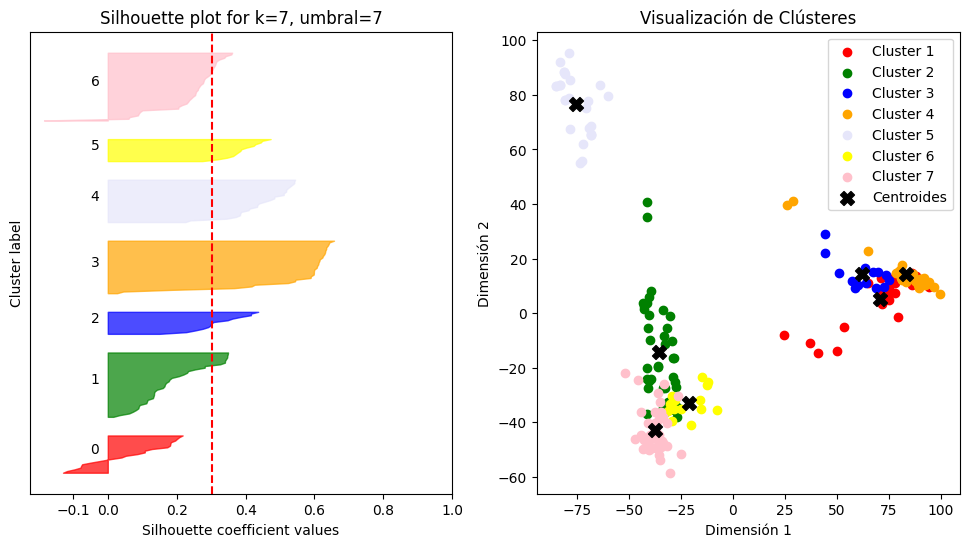

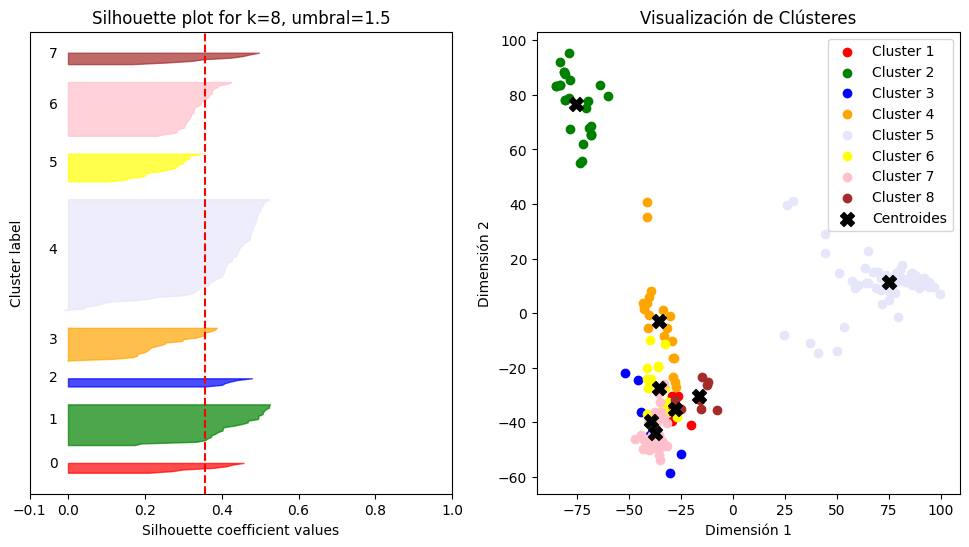

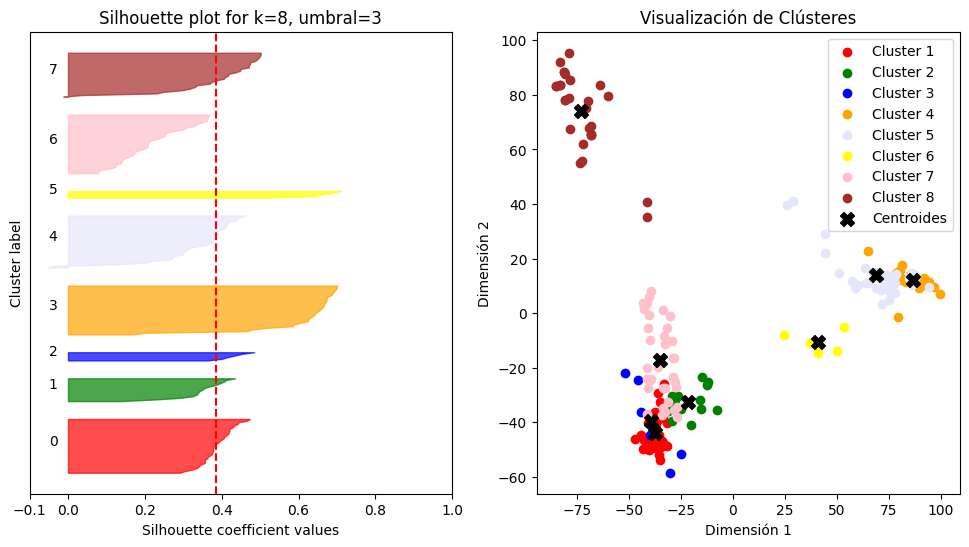

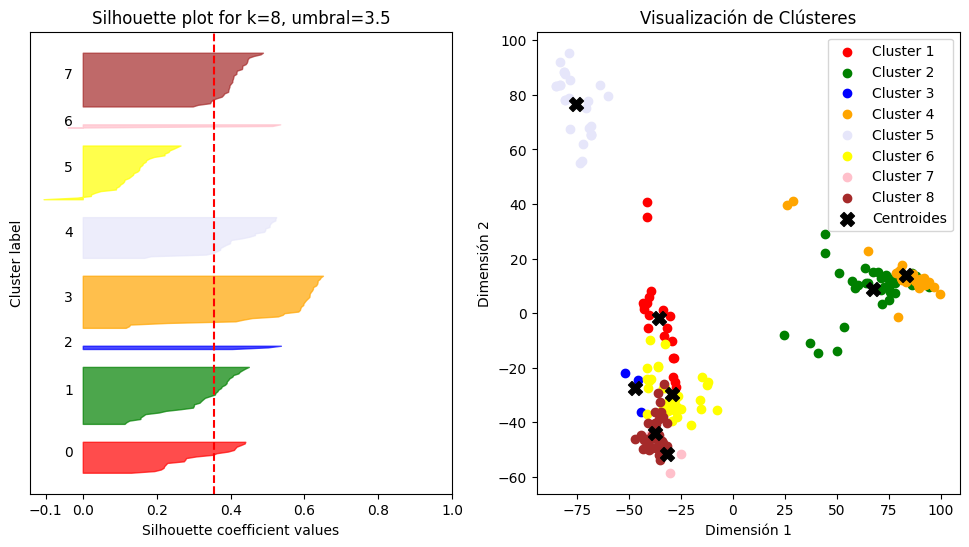

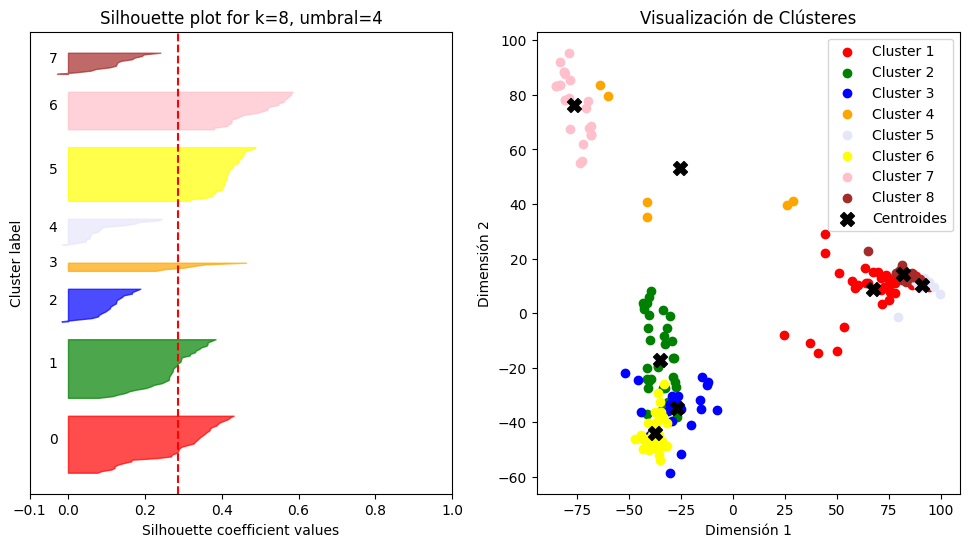

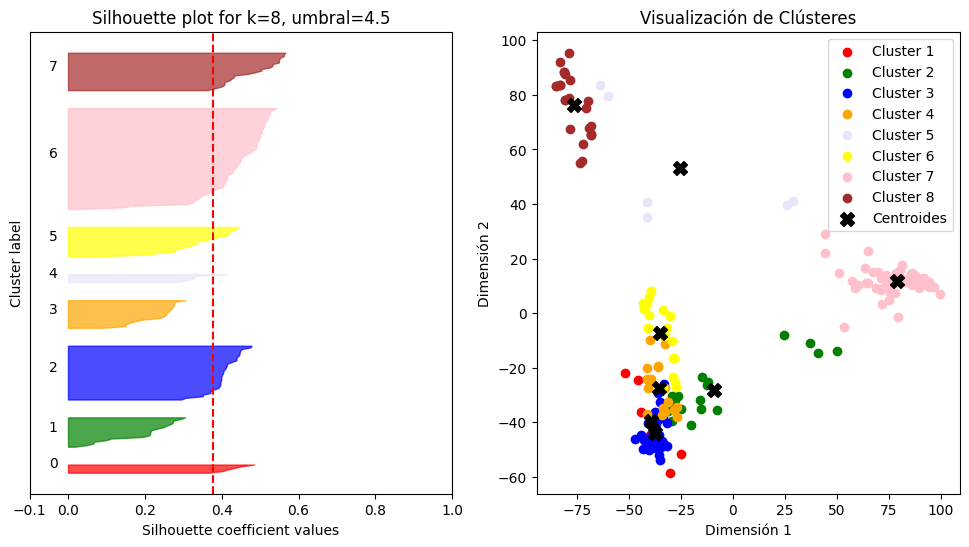

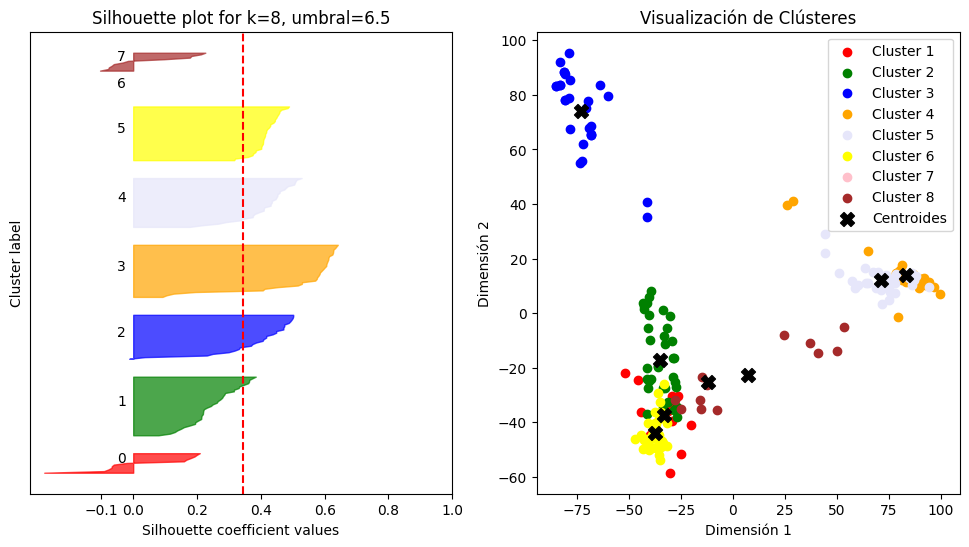

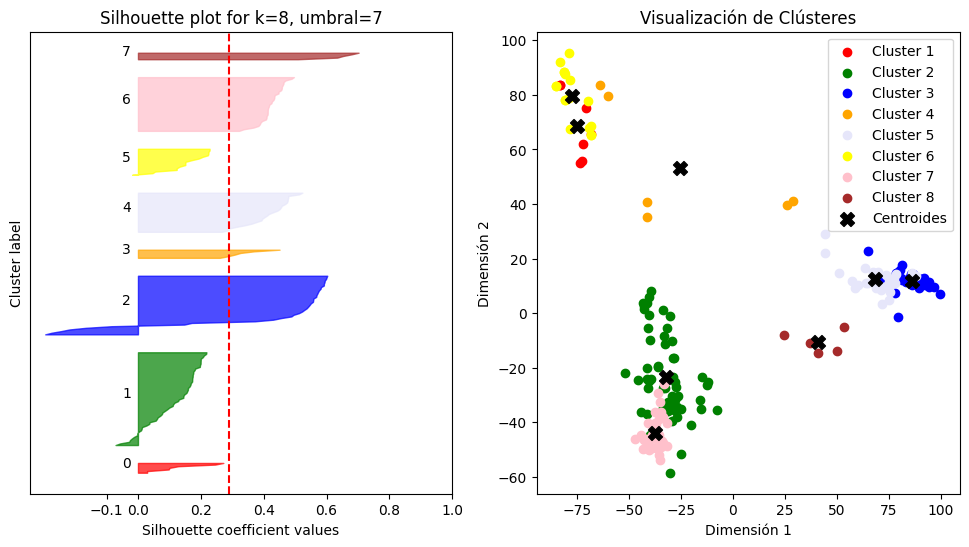

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

k_values = [6,7,8]
umbral_values = [1.5,3,3.5,4,4.5,6.5,7]
colores = ['red', 'green', 'blue', 'orange', 'lavender', 'yellow', 'pink', 'brown', 'gray', 'teal']


for k in k_values:
    for umbral in umbral_values:
        centroides, clusters = kmeans(dt_tissue_pca, k, umbral)

        silhouette_avg = silhouette_score(dt_tissue_pca, clusters)

        sample_silhouette_values = silhouette_samples(dt_tissue_pca, clusters)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

        y_lower = 10
        for i in range(k):
            ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = colores[i % len(colores)]
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

        ax1.set_title("Silhouette plot for k={}, umbral={}".format(k, umbral))
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        for cluster_id in range(k): 
            cluster_points = dt_tissue_pca[clusters == cluster_id]  
            ax2.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colores[cluster_id], label=f'Cluster {cluster_id+1}')

        ax2.scatter(centroides[:, 0], centroides[:, 1], s=100, c='black', marker='X', label='Centroides')

        ax2.set_xlabel('Dimensión 1')
        ax2.set_ylabel('Dimensión 2')
        ax2.set_title('Visualización de Clústeres')
        ax2.legend()

        plt.show()

# Decisión final
La gráfica elegida es aquella con 7 clusters y 1.5 de umbral. $\\$


Índice de Rand ajustado: 0.9080778053874125


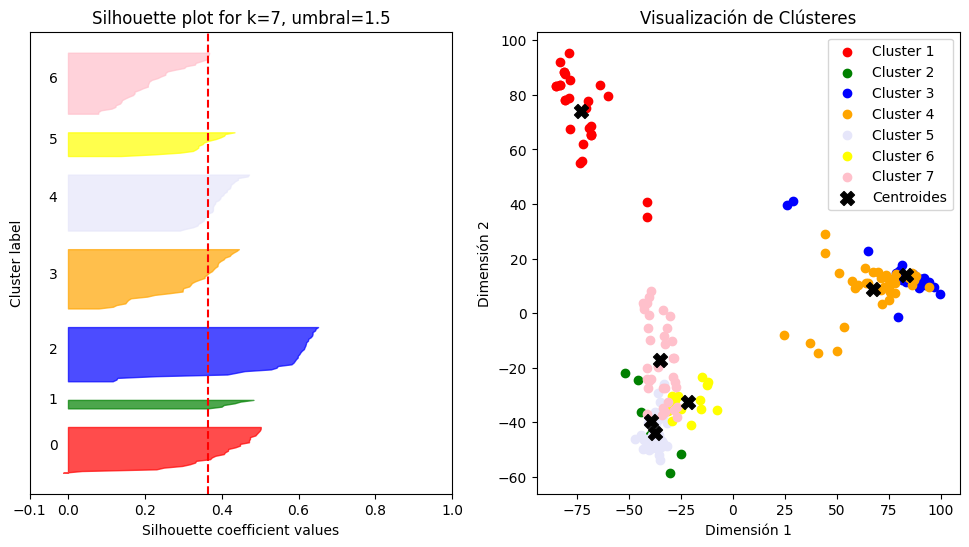

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics.cluster import adjusted_rand_score

k_values = [7]
umbral_values = [1.5]
colores = ['red', 'green', 'blue', 'orange', 'lavender', 'yellow', 'pink', 'brown', 'gray', 'teal']
df_true = pd.read_csv('./dataset/clase.txt', index_col=0, usecols=[0, 1], skiprows=0)
labels_true =df_true.values.flatten()

for k in k_values:
    for umbral in umbral_values:
        centroides, clusters = kmeans(dt_tissue_pca, k, umbral)

        silhouette_avg = silhouette_score(dt_tissue_pca, clusters)

        sample_silhouette_values = silhouette_samples(dt_tissue_pca, clusters)

        rand_index = adjusted_rand_score(labels_true,clusters)
        print(f'Índice de Rand ajustado: {rand_index}')

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

        y_lower = 10
        for i in range(k):
            ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = colores[i % len(colores)]
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

        ax1.set_title("Silhouette plot for k={}, umbral={}".format(k, umbral))
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        for cluster_id in range(k): 
            cluster_points = dt_tissue_pca[clusters == cluster_id]  
            ax2.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colores[cluster_id], label=f'Cluster {cluster_id+1}')

        ax2.scatter(centroides[:, 0], centroides[:, 1], s=100, c='black', marker='X', label='Centroides')

        ax2.set_xlabel('Dimensión 1')
        ax2.set_ylabel('Dimensión 2')
        ax2.set_title('Visualización de Clústeres')
        ax2.legend()

        plt.show()


# Guardando esta información

In [38]:
np.savetxt('clusters.txt',clusters, fmt='%d')
np.savetxt('centroides.txt',centroides, fmt='%f')

# Recuperando la información 

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA

df_tissue = pd.read_csv('./dataset/dataset_tissue.txt',sep=',',index_col=0)
df_clases = pd.read_csv('./dataset/clase.txt',sep=',',index_col=0)
clusters = np.loadtxt('clusters.txt', dtype=int)
centroides = np.loadtxt('centroides.txt', dtype=float)

df_tissue_transposed = df_tissue.T
n_components = 70
pca = PCA(n_components=n_components)
dt_tissue_pca = pca.fit_transform(df_tissue_transposed)

In [ ]:
colores = ['red', 'green', 'blue', 'orange', 'lavender', 'yellow', 'pink', 'brown', 'gray', 'teal']
df_true = pd.read_csv('./dataset/clase.txt', index_col=0, usecols=[0, 1], skiprows=0)
labels_true =df_true.values.flatten()

silhouette_avg = silhouette_score(dt_tissue_pca, clusters)
sample_silhouette_values = silhouette_samples(dt_tissue_pca, clusters)
rand_index = adjusted_rand_score(labels_true,clusters)
print(f'Índice de Rand ajustado: {rand_index}')
k_values = [7]
umbral_values = [1.5]

for k in k_values:
    for umbral in umbral_values:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
        y_lower = 10

        for i in range(k):
            ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = colores[i % len(colores)]
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

        ax1.set_title("Silhouette plot for k={}, umbral={}".format(k, umbral))
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        for cluster_id in range(k): 
            cluster_points = dt_tissue_pca[clusters == cluster_id]  
            ax2.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colores[cluster_id], label=f'Cluster {cluster_id+1}')

        ax2.scatter(centroides[:, 0], centroides[:, 1], s=100, c='black', marker='X', label='Centroides')

        ax2.set_xlabel('Dimensión 1')
        ax2.set_ylabel('Dimensión 2')
        ax2.set_title('Visualización de Clústeres')
        ax2.legend()

        plt.show()